# Ex 2 - Transfer learning
##### Group: 26
By Drilon & Chia-hua

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds  # first: pip install tensorflow_datasets
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

## Load the Dataset and visualize it

In [2]:
# Download and split the food101 dataset
(train_ds, validation_ds, test_ds), info = tfds.load(
    "food101",
    split=["train", "validation[:50%]", "validation[50%:]"],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteQFHKZ8/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteQFHKZ8/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [3]:
# Filter the dataset to keep the first 20 classes only.
N_CLASSES = 20
CLASS_NAMES = info.features['label'].names[:N_CLASSES]

train_ds = train_ds.filter(lambda img, label: label < N_CLASSES)
validation_ds = validation_ds.filter(lambda img, label: label < N_CLASSES)
test_ds = test_ds.filter(lambda img, label: label < N_CLASSES)

In [4]:
# This step takes too much time. It is not madatory to execute it.
print("Training samples: %d" % train_ds.reduce(0, lambda x,_: x+1).numpy())
print("Validation samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())
print("Tests samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())

Training samples: 15000
Validation samples: 2514
Tests samples: 2514


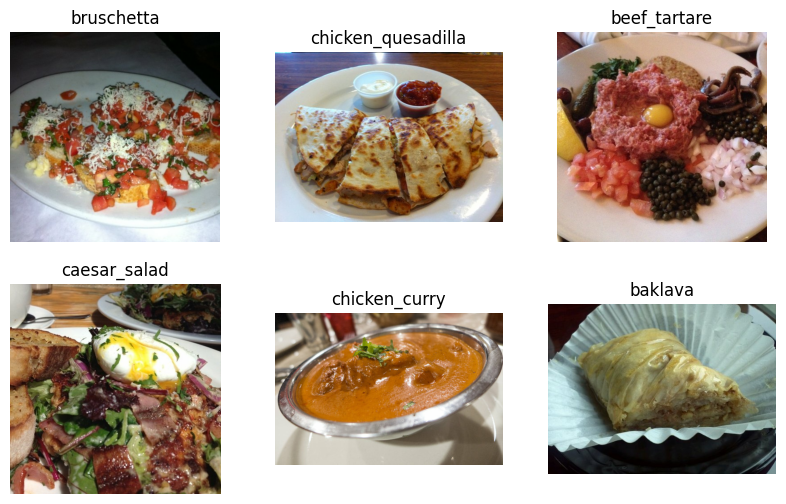

In [5]:
plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label])
    plt.axis("off")

## Resize and normalize

In [6]:
# TODO Resize the images in the training, validation and test set
IMG_SIZE = 224
BATCH_SIZE = 64

def resize_image(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

train_ds = train_ds.map(resize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_ds = validation_ds.map(resize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(resize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [7]:
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_ds = validation_ds.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [8]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, N_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_encode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_ds = validation_ds.map(one_hot_encode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(one_hot_encode, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# batching and pre-fetching
train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_ds = validation_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Data-Augmentation

In [ ]:
# Optional define/implements data-augmentation

## Training
### Step 1: Only train the head of the network

In [ ]:
%%time
# Load the pretrained model from the available models: https://keras.io/api/applications/#available-models.
# Load the imagenet weights but do not include the ImageNet classifier at the top.
#
# Tip, don't choose models that are too big because the training could take hours.
# A model like mobilenet is more than enough for the exercise.

mobileNetBaseModel = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
# Freeze the base_model
for layer in mobileNetBaseModel.layers:
    layer.trainable = False

# Create the model structure
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = mobileNetBaseModel(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(N_CLASSES, activation='softmax')(x)
modelMobileNet = keras.Model(inputs, outputs)

modelMobileNet.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                

In [ ]:
%%time

# Compile the model with your optimizer, your loss and your metrics
modelMobileNet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Optional: Define and use callbacks
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("modelMobileNet.h5", save_best_only=True)
]

step1_modelMobileNet_history = modelMobileNet.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10,
    callbacks=callbacks,
    batch_size=BATCH_SIZE
)


Epoch 1/10
    235/Unknown - 36s 113ms/step - loss: 1.5699 - accuracy: 0.5285

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


235/235 [==============================] - 43s 140ms/step - loss: 1.5699 - accuracy: 0.5285 - val_loss: 1.0426 - val_accuracy: 0.6826
Epoch 2/10
235/235 [==============================] - 21s 90ms/step - loss: 1.1527 - accuracy: 0.6453 - val_loss: 0.9900 - val_accuracy: 0.6893
Epoch 3/10
235/235 [==============================] - 21s 90ms/step - loss: 1.0103 - accuracy: 0.6829 - val_loss: 0.9506 - val_accuracy: 0.6945
Epoch 4/10
235/235 [==============================] - 21s 91ms/step - loss: 0.9083 - accuracy: 0.7160 - val_loss: 0.9261 - val_accuracy: 0.6997
Epoch 5/10
235/235 [==============================] - 21s 90ms/step - loss: 0.8184 - accuracy: 0.7405 - val_loss: 0.9637 - val_accuracy: 0.6921
Epoch 6/10
235/235 [==============================] - 21s 90ms/step - loss: 0.7353 - accuracy: 0.7607 - val_loss: 0.9416 - val_accuracy: 0.7029
Epoch 7/10
235/235 [==============================] - 21s 90ms/step - loss: 0.6831 - accuracy: 0.7777 - val_loss: 0.9483 - val_accuracy: 0.7013
Ep

In [11]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('Model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_history(step1_modelMobileNet_history, 'loss')

NameError: name 'step1_modelMobileNet_history' is not defined

### Step 2: Fine-Tune the whole model

In [ ]:
%%time


# Unfreeze the pretrained base.
for layer in mobileNetBaseModel.layers:
    layer.trainable = True

# Compile the model again
modelMobileNet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Retrain the model
step2_modelMobileNet_history = modelMobileNet.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
235/235 [==============================] - 96s 307ms/step - loss: 0.7646 - accuracy: 0.7638 - val_loss: 0.8695 - val_accuracy: 0.7188
Epoch 2/20
235/235 [==============================] - 70s 297ms/step - loss: 0.7283 - accuracy: 0.7721 - val_loss: 0.8548 - val_accuracy: 0.7224
Epoch 3/20
235/235 [==============================] - 70s 297ms/step - loss: 0.7061 - accuracy: 0.7792 - val_loss: 0.8447 - val_accuracy: 0.7239
Epoch 4/20
235/235 [==============================] - 70s 296ms/step - loss: 0.6910 - accuracy: 0.7821 - val_loss: 0.8415 - val_accuracy: 0.7255
Epoch 5/20
235/235 [==============================] - 70s 296ms/step - loss: 0.6700 - accuracy: 0.7912 - val_loss: 0.8332 - val_accuracy: 0.7251
Epoch 6/20
235/235 [==============================] - 69s 296ms/step - loss: 0.6561 - accuracy: 0.7922 - val_loss: 0.8294 - val_accuracy: 0.7287
Epoch 7/20
235/235 [==============================] - 70s 296ms/step - loss: 0.6525 - accuracy: 0.7951 - val_loss: 0.8245 - val_ac

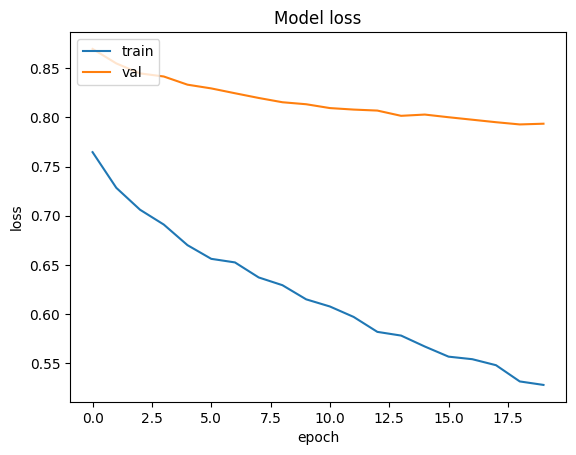

In [ ]:
plot_history(step2_modelMobileNet_history, 'loss')

## Test the fine-tuned model

In [ ]:
%%time
# Predict the test set
y_pred = modelMobileNet.predict(test_ds, verbose=1)

# De-encode the onehot encoded labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

39/39 [==============================] - 5s 107ms/step
CPU times: user 5.39 s, sys: 2.59 s, total: 7.98 s
Wall time: 5.22 s


In [ ]:
%%time

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.7485921158487531
CPU times: user 229 µs, sys: 2.07 ms, total: 2.3 ms
Wall time: 1.87 ms


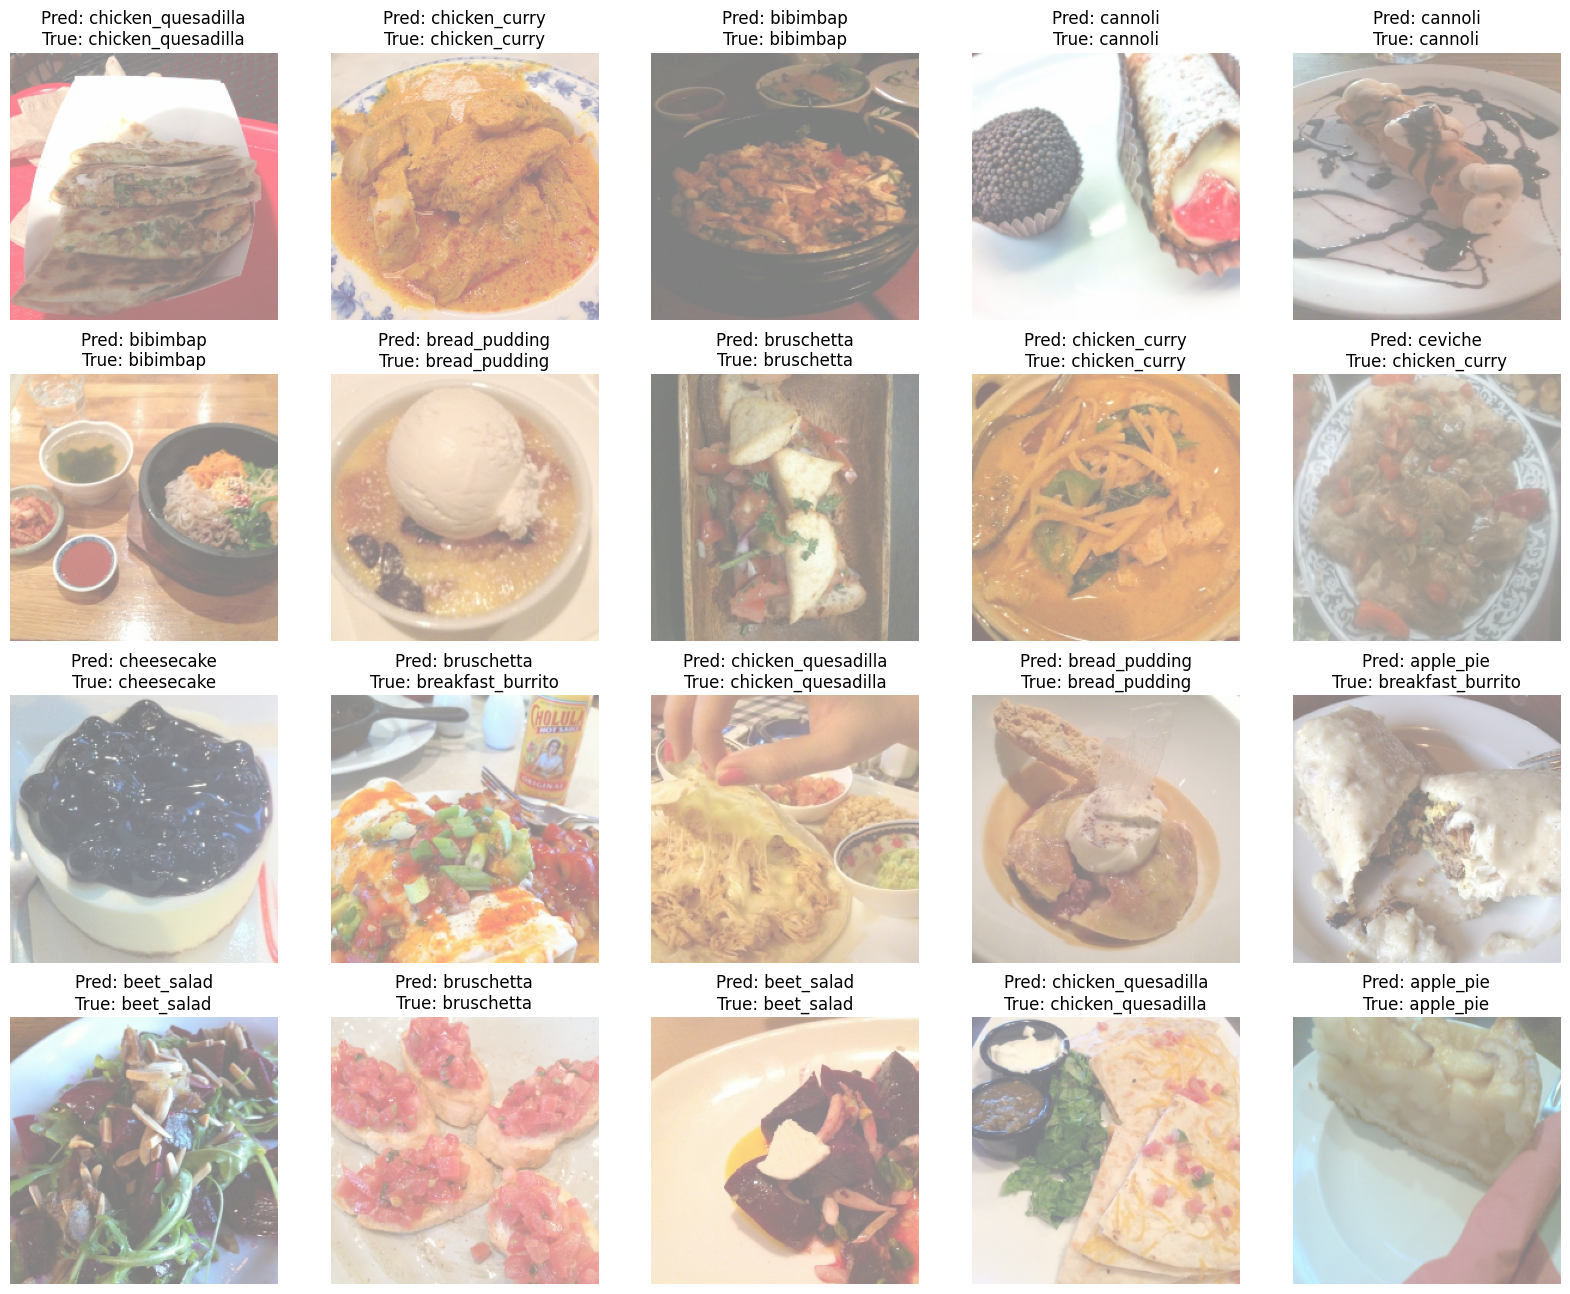

In [ ]:
def show_images_prediction(page=0):
    test_examples = (np.concatenate([x.numpy() for x, y in test_ds])+1)/2*255
    test_examples = test_examples.astype("uint32")

    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(20, 16)

    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(test_examples[i+start_i])
        ax.set_axis_off()
        ax.set_title("Pred: "+CLASS_NAMES[y_pred[i+start_i]]+"\nTrue: "+CLASS_NAMES[y_true[i+start_i]])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    plt.show()
show_images_prediction(2)

In [9]:
%%time

inceptionBaseModel = tf.keras.applications.InceptionV3(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
for layer in inceptionBaseModel.layers:
  layer.trainable = False

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = inceptionBaseModel(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(N_CLASSES, activation='softmax')(x)
inceptionModel = keras.Model(inputs, outputs)

inceptionModel.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 20)                10260  

Epoch 1/10
235/235 [==============================] - 42s 163ms/step - loss: 0.7218 - accuracy: 0.7691 - val_loss: 1.1390 - val_accuracy: 0.6706
Epoch 2/10
235/235 [==============================] - 36s 155ms/step - loss: 0.6668 - accuracy: 0.7813 - val_loss: 1.1334 - val_accuracy: 0.6667
Epoch 3/10
235/235 [==============================] - 36s 152ms/step - loss: 0.6227 - accuracy: 0.7964 - val_loss: 1.1657 - val_accuracy: 0.6722
Epoch 4/10
235/235 [==============================] - 36s 153ms/step - loss: 0.5811 - accuracy: 0.8079 - val_loss: 1.1656 - val_accuracy: 0.6611
Epoch 5/10
235/235 [==============================] - 36s 153ms/step - loss: 0.5475 - accuracy: 0.8179 - val_loss: 1.2292 - val_accuracy: 0.6607
Epoch 6/10
235/235 [==============================] - 36s 153ms/step - loss: 0.5164 - accuracy: 0.8314 - val_loss: 1.2201 - val_accuracy: 0.6627
Epoch 7/10
235/235 [==============================] - 36s 154ms/step - loss: 0.4722 - accuracy: 0.8427 - val_loss: 1.2523 - val_ac

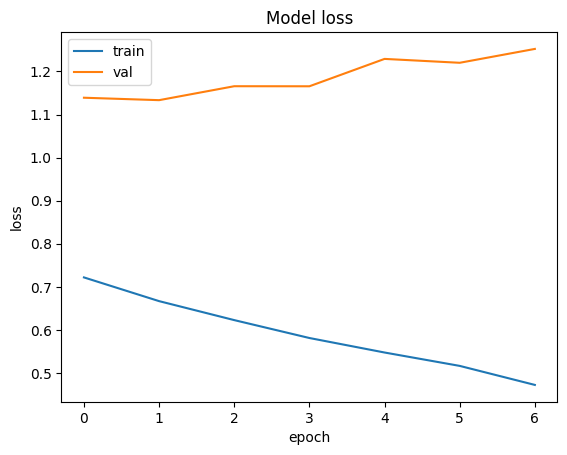

CPU times: user 1min 10s, sys: 1min 9s, total: 2min 19s
Wall time: 4min 18s


In [12]:
%%time

# Compile the model with your optimizer, your loss and your metrics
inceptionModel.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Optional: Define and use callbacks
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("inceptionModel.h5", save_best_only=True)
]

step1_inceptionModel_history = inceptionModel.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10,
    callbacks=callbacks,
    batch_size=BATCH_SIZE
)

plot_history(step1_inceptionModel_history, 'loss')

In [13]:
# Unfreeze the pretrained base.
for layer in inceptionBaseModel.layers:
  layer.trainable = True

# Compile the model again
inceptionModel.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Retrain the model
step2_inceptionModel_history = inceptionModel.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
235/235 [==============================] - 156s 506ms/step - loss: 0.5552 - accuracy: 0.8198 - val_loss: 1.0692 - val_accuracy: 0.6969
Epoch 2/20
235/235 [==============================] - 112s 475ms/step - loss: 0.4752 - accuracy: 0.8486 - val_loss: 1.0697 - val_accuracy: 0.6993
Epoch 3/20
235/235 [==============================] - 112s 475ms/step - loss: 0.4197 - accuracy: 0.8655 - val_loss: 1.0710 - val_accuracy: 0.7029
Epoch 4/20
235/235 [==============================] - 112s 475ms/step - loss: 0.3798 - accuracy: 0.8805 - val_loss: 1.0767 - val_accuracy: 0.7037
Epoch 5/20
235/235 [==============================] - 112s 475ms/step - loss: 0.3479 - accuracy: 0.8908 - val_loss: 1.0846 - val_accuracy: 0.7049
Epoch 6/20
235/235 [==============================] - 112s 475ms/step - loss: 0.3133 - accuracy: 0.9049 - val_loss: 1.0930 - val_accuracy: 0.7037


In [14]:
plot_history(step2_inceptionModel_history, 'loss')

In [15]:
%%time
# Predict the test set
y_pred = inceptionModel.predict(test_ds, verbose=1)

# De-encode the onehot encoded labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

39/39 [==============================] - 10s 232ms/step
CPU times: user 33.4 s, sys: 5.02 s, total: 38.5 s
Wall time: 10.6 s


In [16]:
%%time

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.6850362027353177
CPU times: user 1.93 ms, sys: 0 ns, total: 1.93 ms
Wall time: 1.61 ms


In [18]:
def show_images_prediction(page=0):
    test_examples = (np.concatenate([x.numpy() for x, y in test_ds])+1)/2*255
    test_examples = test_examples.astype("uint32")

    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(20, 16)

    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(test_examples[i+start_i])
        ax.set_axis_off()
        ax.set_title("Pred: "+CLASS_NAMES[y_pred[i+start_i]]+"\nTrue: "+CLASS_NAMES[y_true[i+start_i]])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    plt.show()
show_images_prediction(2)

we now practiced transfer learning using two different base models, MobileNetV2 and InceptionV3, and added just a few layers on top. Although the accuracy we achieved was around 70%, since we're working with the Food101 dataset, which is known to be a challenging classification problem. Given the minimal effort put into designing these models, we are already quite satisfied with this performance. This demonstrates the effectiveness of transfer learning even with simple modifications.